# Imports

In [1]:
%matplotlib inline
import datetime as dt
import pandas_datareader as pdr
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

import MPT.PortfolioContainer
import MPT.ReturnsGetter
import MPT.StockPlotter
import MPT.SingleIndexModel
import MPT.TangencyPortfolio
import MPT.TreynorPortfolio

/usr/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
reload(MPT.StockPlotter)
reload(MPT.SingleIndexModel)
reload(MPT.ReturnsGetter)
reload(MPT.PortfolioContainer)
reload(MPT.TangencyPortfolio)
reload(MPT.TreynorPortfolio)

<module 'MPT.TreynorPortfolio' from '/home/ray/Documents/Finance/myProject/MPT/TreynorPortfolio.py'>

# Stock Visualisation

The csv file `270620.csv` contains historic stock prices (form 2015/01/01 to 01/06/20) for the most actively traded stocks, according to Yahoo finance, on 27/06/20. It was generated from the following code:

In [3]:
#import yfinance as yf
#25 most traded on 27/06/20
#most_traded = ['INO', 'PCG', 'GPS', 'AAL', 'BAC', 'F', 'FB', 'GE', 'WFC', 'UAL', 'T', 'NCLH', 'AMD', 'BA', 'TWTR', 'AAPL', 'NOK', 'CSCO', 'MSFT', 'DAL', 'SNAP', 'NIO', 'JPM', 'CCL', 'C']
#data = yf.download(most_traded, start = "2015-1-1", end = "2020-6-1")
#data.to_csv('270620.csv')

We shall read the data into a `DataFrame`. Note that this is multi-index data; attributes are listed (`Adj Close`, `Close`, `High`, `Low`, `Open`, `Volume`) at level 0 and stock names at level 1. We thus pass a `header` arugment when reading in the csv file:

In [4]:
import pandas as pd
full = pd.read_csv('270620.csv', index_col = [0], parse_dates = True, header = [0,1])
print(full)

            Adj Close                                                \
                  AAL        AAPL        AMD          BA        BAC   
Date                                                                  
2015-01-02  51.079918   99.945885   2.670000  112.786011  16.239172   
2015-01-05  51.051483   97.130241   2.660000  112.004875  15.767419   
2015-01-06  50.255585   97.139420   2.630000  110.685638  15.295666   
2015-01-07  50.227158   98.501518   2.580000  112.404106  15.368245   
2015-01-08  50.843037  102.286186   2.610000  114.391670  15.685770   
...               ...         ...        ...         ...        ...   
2020-05-22   9.700000  318.890015  55.169998  137.529999  22.503061   
2020-05-26  11.140000  316.730011  53.189999  144.729996  24.111843   
2020-05-27  11.980000  318.109985  52.740002  149.520004  25.800068   
2020-05-28  10.980000  318.250000  51.740002  149.820007  24.687826   
2020-05-29  10.500000  317.940002  53.799999  145.850006  23.952951   

     

The two levels of columns labels are

In [5]:
level0 = full.columns.levels[0].tolist()
level1 = full.columns.levels[1].tolist()
print(level0)
print(level1)

['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
['AAL', 'AAPL', 'AMD', 'BA', 'BAC', 'C', 'CCL', 'CSCO', 'DAL', 'F', 'FB', 'GE', 'GPS', 'INO', 'JPM', 'MSFT', 'NCLH', 'NIO', 'NOK', 'PCG', 'SNAP', 'T', 'TWTR', 'UAL', 'WFC']


For now, we shall work only the first four stocks for simplicity.

In [6]:
#             get all rows
#                   |       get all columns @ level 0 but only 4 columns @ level 1
#                   |                |
#                   |   |---------------------------|
#                  |-|
stocks4 = full.loc[ : , pd.IndexSlice[:, level1[7:11]] ]
print(stocks4.head())

            Adj Close                                       Close             \
                 CSCO        DAL          F         FB       CSCO        DAL   
Date                                                                           
2015-01-02  23.359201  44.270039  11.675119  78.449997  27.610001  49.180000   
2015-01-05  22.893879  43.531906  11.219061  77.190002  27.059999  48.360001   
2015-01-06  22.885414  42.505718  11.112647  76.150002  27.049999  47.220001   
2015-01-07  23.096928  42.280685  11.431887  76.150002  27.299999  46.970001   
2015-01-08  23.274595  43.378883  11.720727  78.180000  27.510000  48.189999   

                                   High             ...    Low             \
                F         FB       CSCO        DAL  ...      F         FB   
Date                                                ...                     
2015-01-02  15.36  78.449997  28.120001  50.009998  ...  15.18  77.699997   
2015-01-05  14.76  77.190002  27.450001  49.480000 

For whatever reason, there is one row of all `NaN` values. We shall back-fill to eliminte the row:

In [7]:
print(stocks4[stocks4.isnull().any(axis = 1)])
stocks4 = stocks4[stocks4.index != '2017-01-02']

           Adj Close             Close             High      ... Low     Open  \
                CSCO DAL   F  FB  CSCO DAL   F  FB CSCO DAL  ...   F  FB CSCO   
Date                                                         ...                
2017-01-02       NaN NaN NaN NaN   NaN NaN NaN NaN  NaN NaN  ... NaN NaN  NaN   

                       Volume              
           DAL   F  FB   CSCO DAL   F  FB  
Date                                       
2017-01-02 NaN NaN NaN    NaN NaN NaN NaN  

[1 rows x 24 columns]


We shall split the data into two unequal sets: `testing` and `evaluation`. The first set will be used as data that we shall use in constructing portfolios and the second shall be used to evaulate the performance of those portfolios:

In [8]:
testing = stocks4.loc[:'2019-12-31']
evaluation = stocks4.loc['2020-01-01':]

This is called in the `StockPlotter` class below. We shall plot the first 3 months of the `historic` dataset:

In [9]:
stp = MPT.StockPlotter.StockPlotter(testing.loc[:'2015-04-01'])

The function `plotOHLCV` plots an OHLC candlestick plot (left axis) for each stock passed, along with the trade volume (right axis) in the background (note that `matplotlib` has deprecated candlestick plots and so this method hacks one together from the `boxplot` functionality):

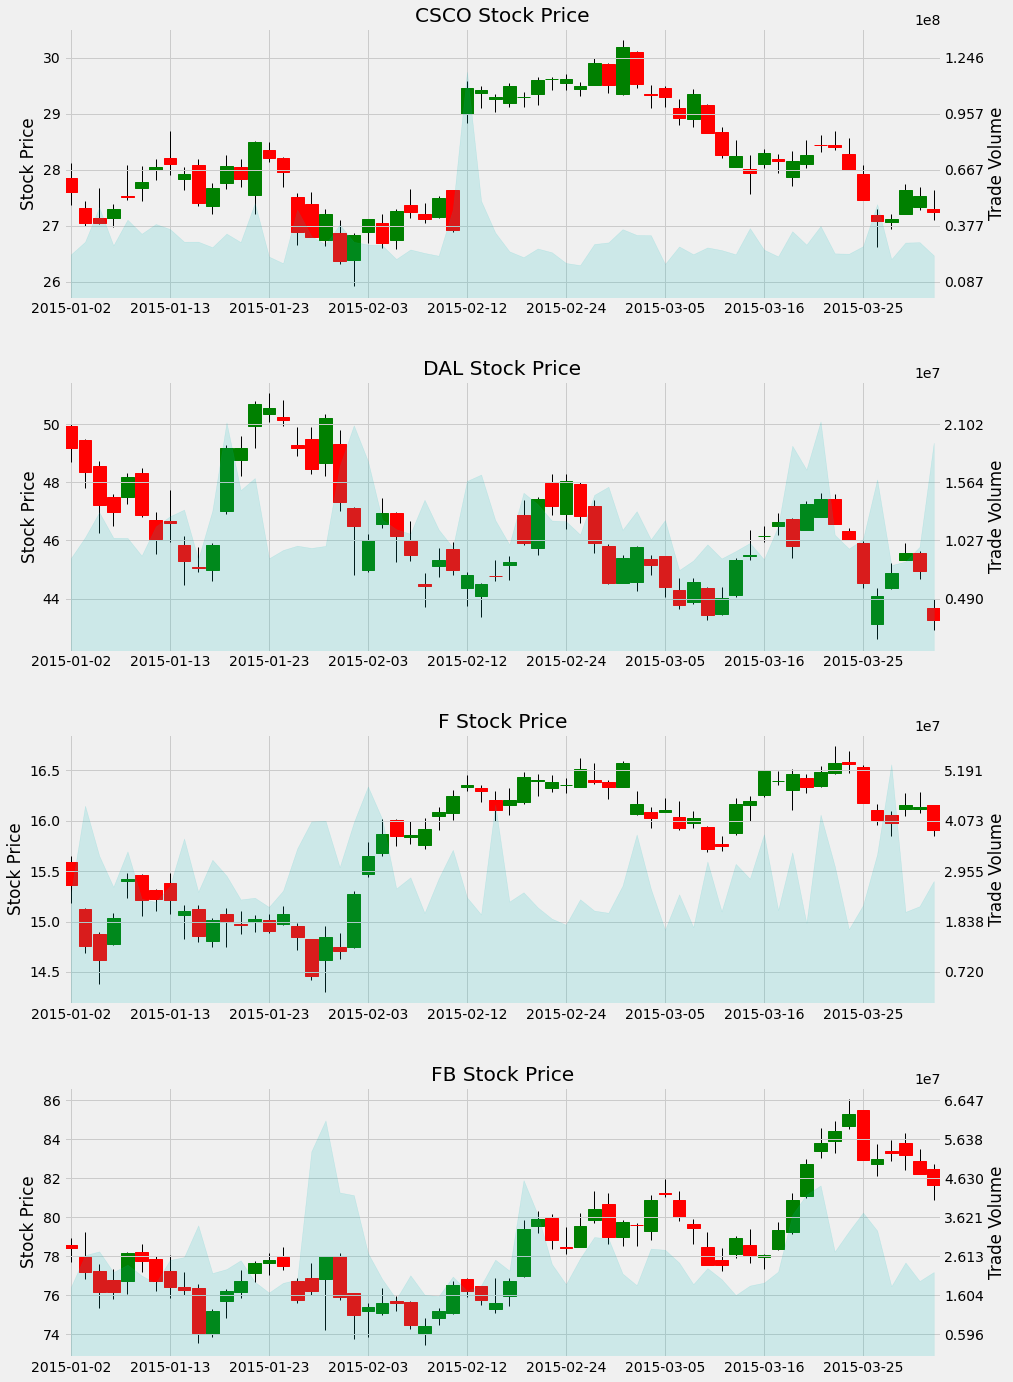

In [10]:
stp.plotOHLCV();

The function `plotDailyReturns` plots a histogram of the daily returns for each stock, along with a KDE of the underlying pdf, to allow one to visually assess the distribution of the returns. We also plot boxplots of these returns including outliers (defined as $1.5 \times  \text{IQR}$ above/below Q3/Q1).

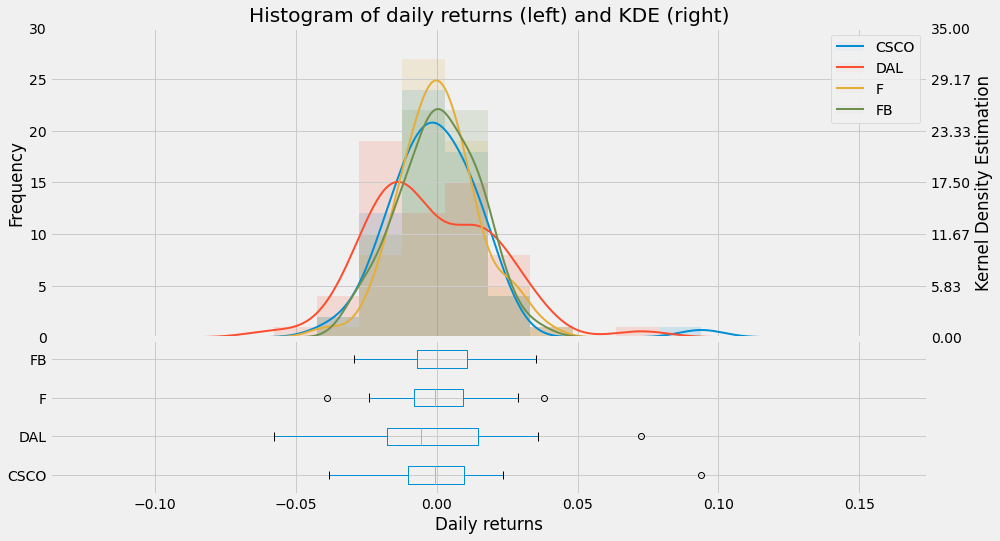

In [11]:
stp.plotDailyReturns();

The boxplots at the bottom revela that `DAL` and `CSCO` are likely not normally distributed. The daily returns of `DAL`, in particular, is noticeably negatively skewed and both have asymmetric whiskers. The other two stocks `FB` and `F` are at least symmetrically distributed but this still does not preculde a leptokurtic distribution. The short whiskers and outliers in `F` further suggest that this might be possible.

## The Single Index Model

The single index model is an extension of the CAPM. Wheras the CAPM expects the abnormal stock returns (stock $\alpha$) to be zero, the single index model allows for aribtrary intercept in the regression of excess returns against excess market returns:

$$
r_{i,t} - r_f = \alpha_i + \beta_i (r_{m,t} - r_f) + \varepsilon_{i,t}\,.
$$

Here, $r_f$ is the risk-free return, $\{r_{i,t}\}$ is a timeseries of the return of the $i^{\text{th}}$ asset, $\{r_{m,t}\}$ is a timeseries of the return of the market portfolio and $\varepsilon_{i,t}$ are the residuals.

For the purposes of these notes, we shall assume that the risk-free return is zero and that some benchmark index (we shall use S&P 500 index `SPY`) can be used as a proxy for the market portfolio. For now, we consider the daily returns of our four stocks and the benchmark:

In [12]:
risk_free_return = 0.
historic_stock_returns = testing['Adj Close'].pct_change()[1:]
historic_benchmark_returns = pdr.get_data_yahoo('SPY', '2015-01-01', '2019-12-31')['Adj Close'].pct_change()[1:]

We can initialise an instance of our implementation of the single index model as follows:

In [13]:
sim = MPT.SingleIndexModel.SingleIndexModel(historic_stock_returns,
                                            historic_benchmark_returns,
                                            risk_free_return)

The above data is sufficient for us to regress the excess returns of the individual stocks and obtain the $\alpha_i$ and $\beta_i$ of each stock. We have also provided a method to plot the individual security characteristic lines (SCL):

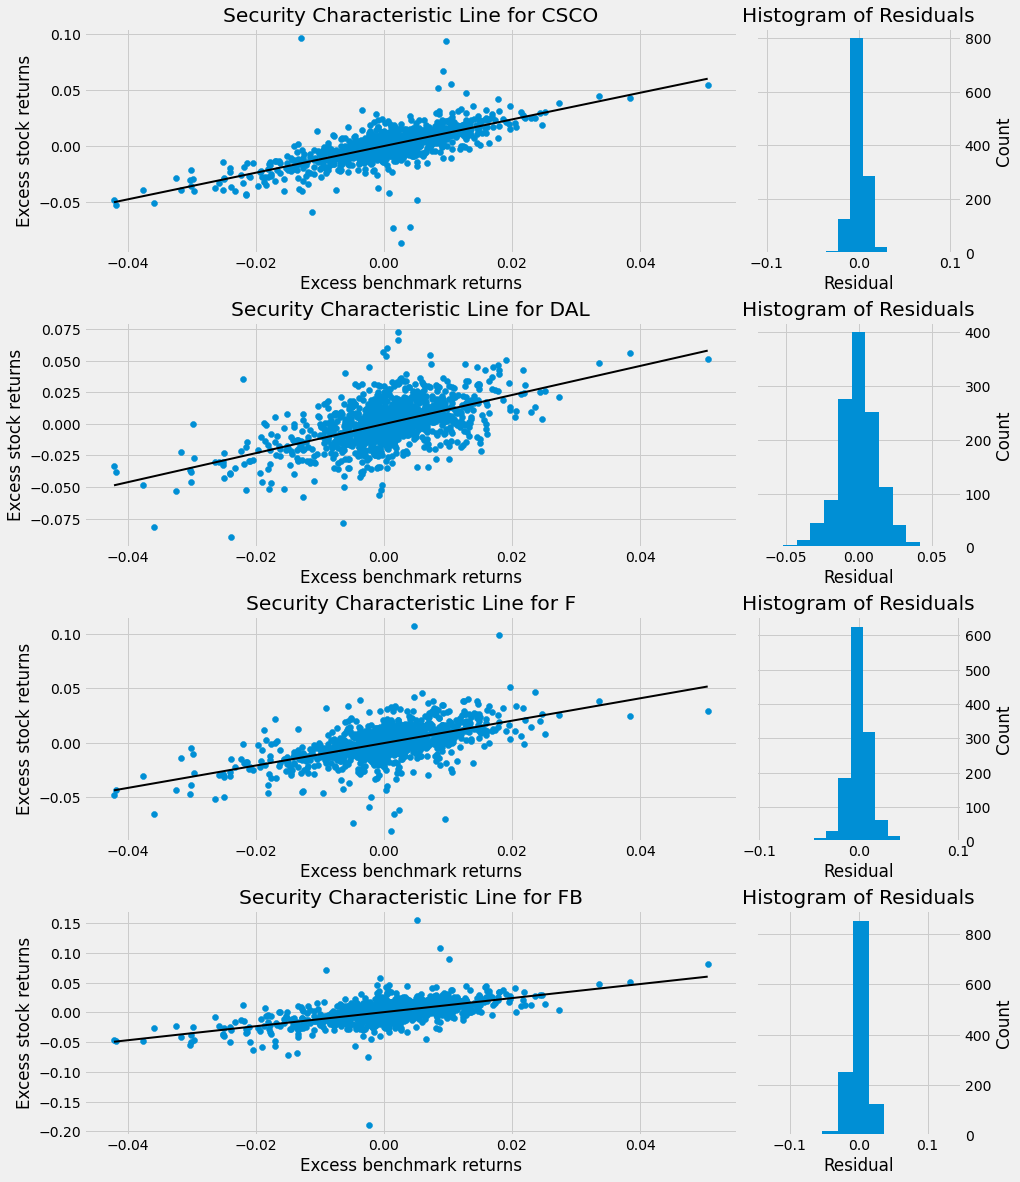

In [14]:
sim.plotSecurityCharacteristicLines();

We have also plotted a histogram of the residuals under this regression. To assess the fitness of the model, these residuals should be $\varepsilon_{i,t} \sim N(0, \sigma^2_i)$ distributed and so should be checked for homoscedasticity (Goldfeld-Quandt test), normality (Jarque-Bera statistic), etc.

We can see, qualitatively, from the above plots that the SLC are relativley good fits (statistical results from the `statsmodels.api.OLS` that quantify this such as R-squared and AIC/BIC etc. are also available) which show that the regressions have converged.

We can access the abnormal returns $\alpha_i$ and systematic risks $\beta_i$ through the attributes `alphas`  and `betas`:

In [15]:
print(sim.alphas)
print(sim.betas)

[ 0.00010013 -0.000174   -0.00056327  0.00036681]
[1.18763549 1.15012698 1.03450183 1.18274073]


Note that, since we passed in daily returns data, the $\alpha_i$ returned above are *daily* abnormal returns. Only two of the four stocks (`CSCO` and `FB`) posted positive abnormal returns ($\alpha_i > 0$) over this period whilst all four presented higher systematic risk than the benchmark $(\beta_i > 1)$.

It may also be instructive to compare the SLC of the various stocks, for which one can use the `plotCompareSecurityCharacteristicLines`:

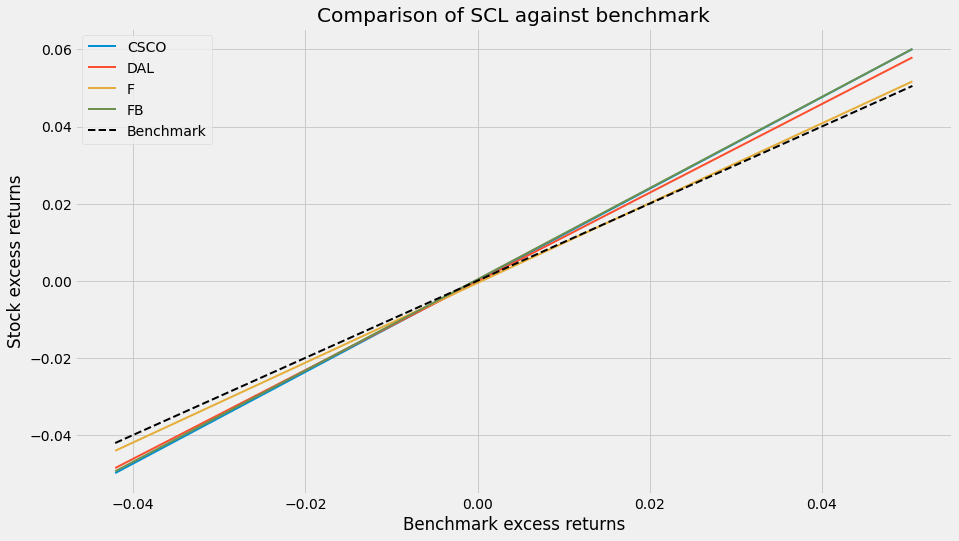

In [16]:
sim.plotCompareSecurityCharacteristicLines()

We reiterate that the intersects give the $\alpha_i$ and the graidents give the $\beta_i$. For comparison, we have also plotted the behchmark SCL as well (which is just a 45-degree line).

# The Efficient Frontier and the Tangency Porfolio

The class `PortfolioContainer` allows for an evaluation of the risk-return spectrum of possible portfolios constructed from the supplied stocks.

In addition to the daily returns of the stock, it also requires some measure of the returns of each stock that was passed to it.

Below, we use `ReturnsGetter` to do this. The default method is `method = anualised` which compute the (geometric mean of the) annualised return of each stock. 

In [17]:
returns_getter = MPT.ReturnsGetter.ReturnsGetter(historic_stock_returns, method = 'annualised')

In [18]:
annualised_returns = returns_getter.get_returns
print(annualised_returns)

[0.15087563235562662, 0.05580099325367205, -0.047687351773634146, 0.2120988716766412]


We see that, contrary to the negative abnormal returns we found above, `DAL` has a positive annualised return; it did generate a positive ROI but it underperformed against the benchmark. The negative return corresponds to `F`.

The `PortfolioContainer` can be constructed as follows

In [19]:
pfc = MPT.PortfolioContainer.PortfolioContainer(historic_stock_returns,
                                                annualised_returns)

We can add portfolios by passing a list of weights (of the same length as the number of stocks) via the `addPortfolio` method. By default, these portfolios are labelled sequentially but we can pass an optional `label` argument to give the portfolios names:

In [20]:
pfc.addPortfolio([0.1,0.4,0.3, 0.2], label = 'My portfolio')
pfc.addPortfolio([0.5, 0.0, 0.0, 0.5])
pfc.listPortfolios()

0) My portfolio: [[0.1 0.4 0.3 0.2]]
1) Portfolio 1: [[0.5 0.  0.  0.5]]


The leading number is the portfolio number which we can pass to the `removePortfolio` to remove it from the container:

In [21]:
pfc.removePortfolio(0)
pfc.listPortfolios()

1) Portfolio 1: [[0.5 0.  0.  0.5]]


The method `plotSampleRiskReturn` plots the risk-return profile of a Monte-Carlo simulation for a visual representation of the portfolio space:

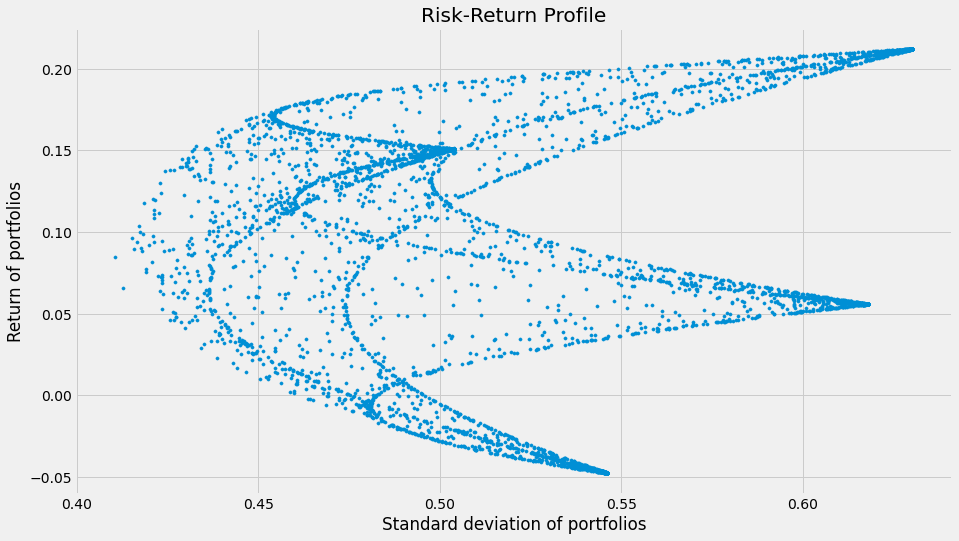

In [22]:
num_samples = 5000
pfc = MPT.PortfolioContainer.PortfolioContainer(historic_stock_returns, annualised_returns)
fig, ax = pfc.plotSampleRiskReturn(num_samples)

Each point plots the return v.s. risk of a simulated portfolio constructed from the stocks passed to the `PortfolioContainer`. We have used `np.random.dirichlet` to construct weights that sum to 1 and tweaked its initisalisation parameters such that it is slightly more likely to generate extereme weights (null and unit weights) that are biased to appear on the boundaries of the risk-return spectrum for easier visualsiation.

We see that a small fraction of these weights give a negative return (presumably those that have a large weighting in `F`). The vertex in the top right corresponds to a portfolio inveseted solely in `FB` which generated the highest returns out of the four stocks at the expense of higher risk.

One might be interested in how the estimate of the expected returns of the stocks affect this plot. Rather than using the annualised rates above, suppose we had used another estimator that yielded the expected returns $[0.1, 0.05, -0.04, 0.2]$. The effect on the risk-return profile can be visualised as follows:

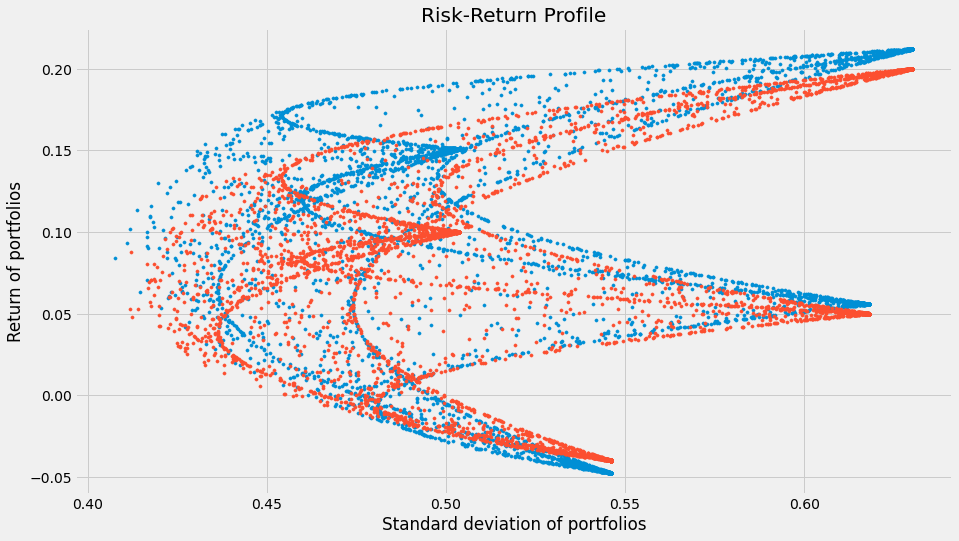

In [23]:
other_returns = [0.1, 0.05, -0.04, 0.2]
pf_1 = MPT.PortfolioContainer.PortfolioContainer(historic_stock_returns, annualised_returns)
pf_2 = MPT.PortfolioContainer.PortfolioContainer(historic_stock_returns, other_returns)
fig, ax = pf_1.plotSampleRiskReturn(5000)
pf_2.plotSampleRiskReturn(5000, fig, ax);

Since this second estimator provided muted estimates of the expected returns, the risk-spectrum has understandably been condensed vertically. Whilst only a simple example, it should be clear that this can be used as a playground for evaluating estimators of exepected returns.

The upper-half of the left-hand edge in a risk-return plot is the Markowitz efficient frontier, for which no portfolios can generate a higher return for the given level of risk. We have implemented a `plotEfficientFrontier` method that plots this separately. Note that this uses `scipy.optimize.basinhopping` at equally spaced sample points and so runs slowly on the first run, particularly with larger numbers of stocks/degrees of freedom. The result is stored internally such that subsequent calls are much faster.

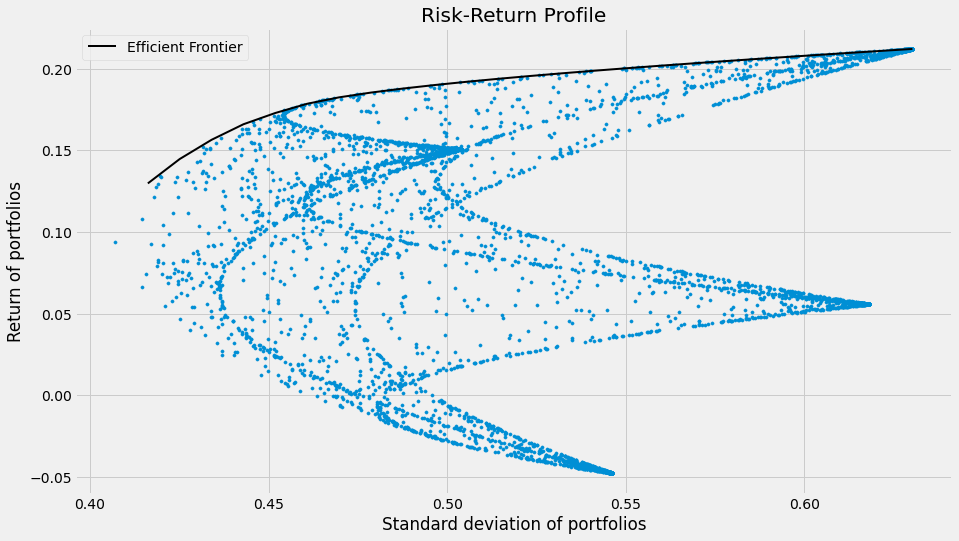

In [24]:
fig, ax = pfc.plotEfficientFrontier()
pfc.plotSampleRiskReturn(5000, fig, ax);

We can see that the choice of sampling has failed slightly at the left-most extreme due to the high curvature of the frontier. A smarter choice of sampling to take this into account will probably improve this, although the current result is sufficient for a heuristic feel.

This type of mean-variance problem with constraints (weights need to sum to zero and weights need to be positive/no shorting) is probably more suited to quadratic programming (QP) techniques e.g. the module `quadprog` acts as a thin wrapper on a C-implmentation of the Goldfarb-Idnani algorithm. We shall not pursue this here.

To this, we can add the *tangency portfolio*. This is the portfolio which maximises the Sharpe ratio, denfied as

$$
\rho_S = \frac{r_\pi - r_f}{\sigma_\pi}\,,
$$

where $r_\pi$ and $\sigma_\pi$ are the portfolio returns and standard deviation respectively.

The class `TangencyPortfolio` is a wrapper for the `PortfolioContainer` that adds the functionality to draw the tangency portfolio and the *capital market line* (CML), which is the capital allocation line (CAL) of the tangency portfolio. We can plot these two object independently, as demonstrated below:

In [25]:
tp = MPT.TangencyPortfolio.TangencyPortfolio(pfc, risk_free_return)

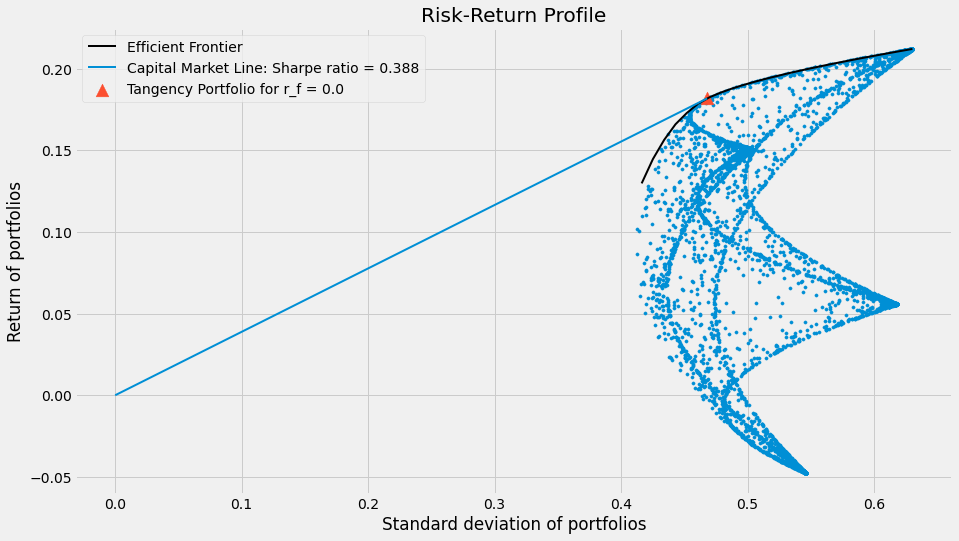

In [26]:
fig, ax = pfc.plotEfficientFrontier()
pfc.plotSampleRiskReturn(5000, fig, ax)
tp.plotTangencyPortfolio(fig, ax)
tp.plotCapitalMarketLine(fig, ax);

Recall that the CAL represents the risk-return profile of all possible portfolios consisting of linear combinations of one risky asset and one riskless asset. It is thus a straight line linking the riskless asset (with zero risk/standard deviation and return given by the risk-free rate, here 0) with the risky asset (here, the tangency portfolio). In particular, the graident of the CAL is equal to the Sharpe ratio of the risky asset. Note that there is one CAL for every possible portfolio; each of the points in the plot above will have their own CAL.

Since the CML is just the CAL of the tangency portfolio and the tangency portfolio was constructed to maximise the Sharpe ratio, it follows that the CML lies above every other possible CAL in this basket; it is the 'most efficient' CAL possible.

We see that the tangency portfolio lies on the efficient fronter as required. Its weights can be accessed from the `tangency_weights` attribute:

In [27]:
print(tp.tangency_weights)

[0.49521804 0.         0.         0.50478196]


We see that, in this case, the tangency portfolio consits of roughly equal allocations in `CSCO` and `FB` (the highest returning stocks) as expected.

The way we have implemented the plotting allows us to assess the effect of the risk-free rate on the tangency portfolio and CML:

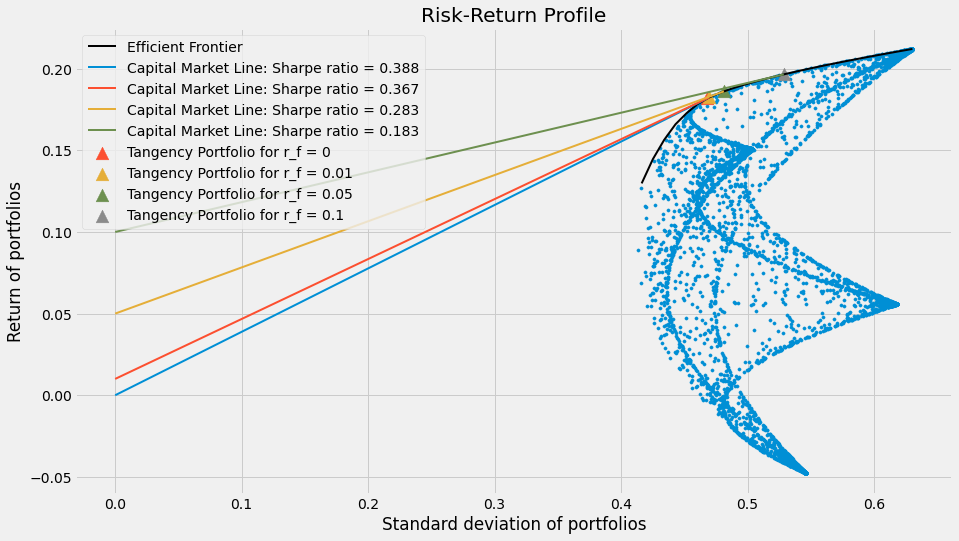

In [28]:
# Iterate over risk-free rates that we are interested in and plot all
# tangency portfolio/CML combinations on teh same plot
rf_rates = [0, 0.01, 0.05, 0.1]
fig, ax = pfc.plotEfficientFrontier()
pfc.plotSampleRiskReturn(num_samples, fig, ax)
for rate in rf_rates:
    tp = MPT.TangencyPortfolio.TangencyPortfolio(pfc, rate)
    tp.plotTangencyPortfolio(fig, ax)
    tp.plotCapitalMarketLine(fig, ax)

We see that the risk-free return pushes the tangency portfolio up the efficient frontier.

# Maximising the Treynor ratio

Another popular raking of a portfolio's risk-return performance is the *Treynor ratio*

$$
T_i = \frac{r_i - r_f}{\beta_i}\,,
$$

where $r_i$ and $\beta_i$ are the $i^{\text{th}}$ asset's returns and systematic risk and $r_f$ is the risk-free return. This requires a benchmark with respect to which we can compute the portfolio $\beta$ and so the class `TreynorPortflio` is built as a wrapper on a `SingleIndexModel` that additionally takes a risk-free rate and adds the functionality to return the weights of the portflio that maximise the Trenyor ratio (henceforth referred to as the *Treynor portfolio*):

In [29]:
treynor = MPT.TreynorPortfolio.TreynorPortfolio(historic_stock_returns,
                                                historic_benchmark_returns,
                                                annualised_returns,
                                                risk_free_return)

The weights of this portflio can be obtained from the `treynor_weights` attribute:

In [30]:
print(treynor.treynor_weights)

[0. 0. 0. 1.]


We can compare the risk-return profile the tangency portfolio and this Treynor portfolio by adding their wieghts to a `PortfolioContainer` and calling the `plotRiskReturn` method:

0) Tangency Portfolio: [[0.49521804 0.         0.         0.50478196]]
1) Treynor Portfolio: [[0. 0. 0. 1.]]


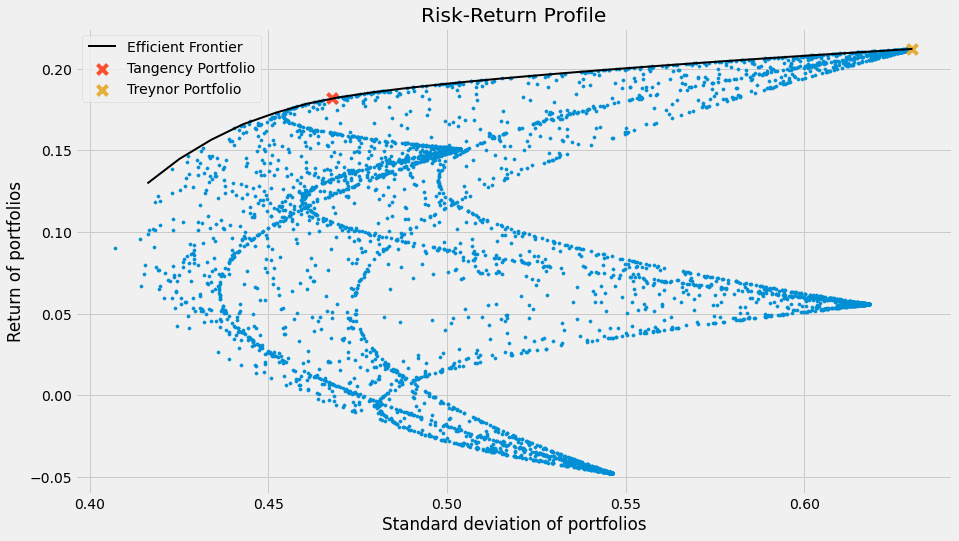

In [31]:
tp = MPT.TangencyPortfolio.TangencyPortfolio(pfc, 0)

pfc.addPortfolio(tp.tangency_weights, label = 'Tangency Portfolio')
pfc.addPortfolio(treynor.treynor_weights, label = 'Treynor Portfolio')
pfc.listPortfolios()
fig, ax = pfc.plotEfficientFrontier()
pfc.plotSampleRiskReturn(5000, fig, ax)
pfc.plotRiskReturn(fig, ax);

# Evaluating Performance

We now have two portfolios constructed from the stock's historic performance from 01/01/2015 to 01/01/2020. We shall now evaluate the returns of these portfolios on the `evaluating` set from 01/01/2020 to 01/06/2020. We thus create a new portfolio container for the evaluation period and add the weights of the tangency and Treynor portfolios *from the testing period*. We also add four randomly generated portfolios as a comparison.

In [32]:
# get the daily returns for the evaluation period
evaluation_returns = evaluation['Adj Close'].pct_change()[1:]

# Add portfolios
eval_portfolio_container = MPT.PortfolioContainer.PortfolioContainer(evaluation_returns, annualised_returns)
eval_portfolio_container.addPortfolio(tp.tangency_weights, 'Tangency pf')
eval_portfolio_container.addPortfolio(treynor.treynor_weights, 'Treynor pf')
for _ in range(4):
    eval_portfolio_container.addPortfolio(np.random.dirichlet(np.ones(4)))
    
# List the portfolios
eval_portfolio_container.listPortfolios()

0) Tangency pf: [[0.49521804 0.         0.         0.50478196]]
1) Treynor pf: [[0. 0. 0. 1.]]
2) Portfolio 2: [[0.49910216 0.20296937 0.26081561 0.03711287]]
3) Portfolio 3: [[0.0235173  0.49961028 0.23971504 0.23715738]]
4) Portfolio 4: [[0.37560485 0.34378992 0.14514355 0.13546167]]
5) Portfolio 5: [[0.07060497 0.68131726 0.10919074 0.13888703]]


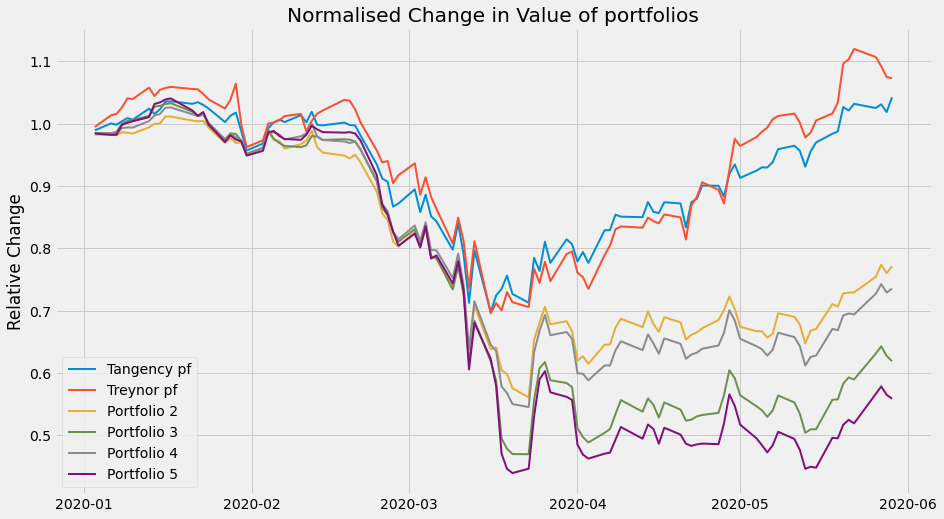

In [33]:
eval_portfolio_container.plotNormalisedPortfolios();

We see that both of the constructed portfolios outperformed the randomly generated portfolios by quite a margin. In fact, both have managed to recover the losses they incurred due to the coronavirus pandemic in Febuary 2020 onwards whilst the randomly generated portfolios have not.

Below, we plot the efficient frontier and the risk-return of the portfolios that we propagated into the evaluation period.

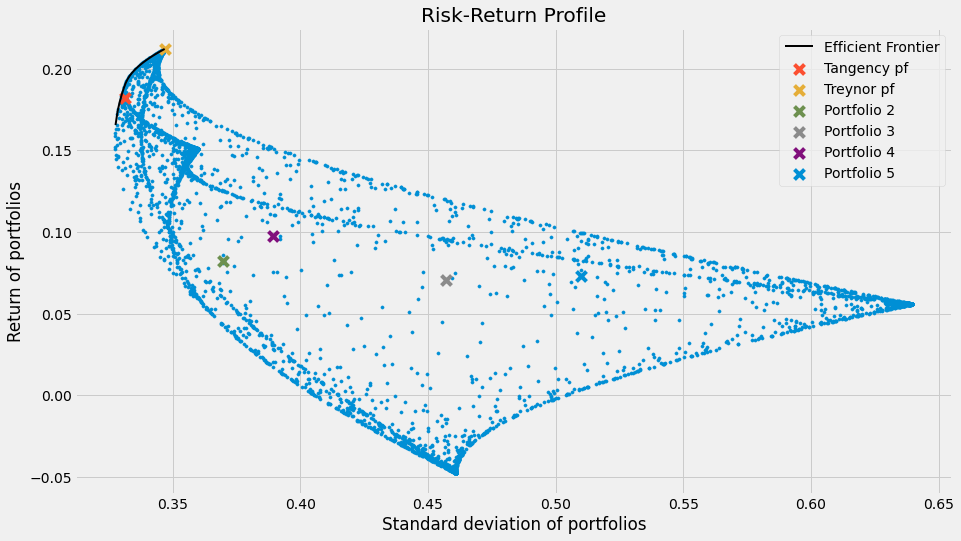

In [34]:
fig, ax = eval_portfolio_container.plotEfficientFrontier()
eval_portfolio_container.plotSampleRiskReturn(5000, fig, ax)
eval_portfolio_container.plotRiskReturn(fig, ax);

We see that the risk-return spectrum has shifted considerably from the five years previously. The tangency portfolio has fallen off the efficient frontier, indicating that the tangency porftolio of the five years to 01/01/2020 differs from the tangency portfolio from 01/01/2020 to 01/06/2020, which is to be expected.

Nevertheless, this drift does not seem significant relative to the transformation of the entire risk-return spectrum.

# Evaluating Performance with all 25 stocks

Above, we only considered 4 of the 25 stocks whose data we pulled for clarity. We now demonstrate the same process using all of the stocks.

In [35]:
full = full[full.index != '2017-01-02']#Remove the full row of NaN
test_full = full['Adj Close'].loc[:'2019-12-31'].pct_change()[1:]
eval_full = full['Adj Close'].loc['2020-01-01':].pct_change()[1:]

We shall use the historic data to compute the annualised returns for all 25 stocks:

In [38]:
rg_t = MPT.ReturnsGetter.ReturnsGetter(test_full)

Create a `PortfolioContainer` using historic daily returns and these expected returns:

In [39]:
pfc_t = MPT.PortfolioContainer.PortfolioContainer(test_full, rg_t.get_returns)

We now initialise an instance of `TangencyPortfolio` to get the weights of the tangency portfolio that maximises the SHarpe ratio:

In [41]:
tp = MPT.TangencyPortfolio.TangencyPortfolio(pfc_t, 0)
print(tp.tangency_weights)

[2.11940330e-16 1.30439747e-02 1.87005442e-01 1.38161269e-01
 1.50303354e-17 0.00000000e+00 2.97790176e-16 0.00000000e+00
 0.00000000e+00 3.87700583e-17 2.09052217e-16 2.99642632e-16
 0.00000000e+00 0.00000000e+00 1.41279819e-01 5.20509495e-01
 1.27464559e-16 0.00000000e+00 1.15251985e-16 2.01796541e-16
 1.48295270e-16 0.00000000e+00 0.00000000e+00 2.29821287e-16
 1.32731723e-17]


To compute the Treynor portfolio, we additionally require a benchmark and risk-free return against which we can compute the portfolios' beta:

In [42]:
historic_benchmark_returns = pdr.get_data_yahoo('SPY', '2015-01-01', '2019-12-31')['Adj Close'].pct_change()[1:]
treynor = MPT.TreynorPortfolio.TreynorPortfolio(test_full,
                                                historic_benchmark_returns,
                                                rg.get_returns,
                                                risk_free_return)

The weights of the Treynor portfolio of these 25 stocks are

In [43]:
print(treynor.treynor_weights)

[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 7.58856512e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.50449721e-17
 6.02515928e-17 2.30977454e-17 0.00000000e+00 4.04190570e-16
 0.00000000e+00 0.00000000e+00 1.76466102e-17 0.00000000e+00
 0.00000000e+00 2.20239273e-16 1.43877264e-16 0.00000000e+00
 0.00000000e+00]


The Treynor portfolio in this case consists entirely of `AMD` and thus has not been diversified at all. This suggests the Treynor ratio does not penalise risk sufficiently to encourage diversification.

We are now ready to propagate these two portfolios into the evaulation period to assess their performance. We create a new `PortfolioContainer` for the evaluation set (01/01/2020---01/06/2020) and add the two portfolios we constructed, as well as 5 randomly generated portfolios for comparison:

In [49]:
# New Portfolio Container for the evaluation period
pfc_e = MPT.PortfolioContainer.PortfolioContainer(eval_full, rg.get_returns)

# Add the tangency and Treynor portfolios
pfc_e.addPortfolio(tp.tangency_weights, 'Tangency Portfolio')
pfc_e.addPortfolio(treynor.treynor_weights, 'Treynor Portfolio')

# Add 5 random portfolios
for _ in range(5):
    pfc_e.addPortfolio(np.random.dirichlet(np.ones(25)))
    
# List our portfolios
pfc_e.listPortfolios()

0) Tangency Portfolio: [[2.11940330e-16 1.30439747e-02 1.87005442e-01 1.38161269e-01
  1.50303354e-17 0.00000000e+00 2.97790176e-16 0.00000000e+00
  0.00000000e+00 3.87700583e-17 2.09052217e-16 2.99642632e-16
  0.00000000e+00 0.00000000e+00 1.41279819e-01 5.20509495e-01
  1.27464559e-16 0.00000000e+00 1.15251985e-16 2.01796541e-16
  1.48295270e-16 0.00000000e+00 0.00000000e+00 2.29821287e-16
  1.32731723e-17]]
1) Treynor Portfolio: [[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 7.58856512e-17 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 7.50449721e-17
  6.02515928e-17 2.30977454e-17 0.00000000e+00 4.04190570e-16
  0.00000000e+00 0.00000000e+00 1.76466102e-17 0.00000000e+00
  0.00000000e+00 2.20239273e-16 1.43877264e-16 0.00000000e+00
  0.00000000e+00]]
2) Portfolio 2: [[0.02531816 0.00894103 0.04530807 0.12616908 0.09631939 0.03666578
  0.00363487 0.03254993 0.02600985 0.06304638 0.06758126 0.02614254
  0.17958784 0.013987

We plot the performance of these portfolios over the evaluation period:

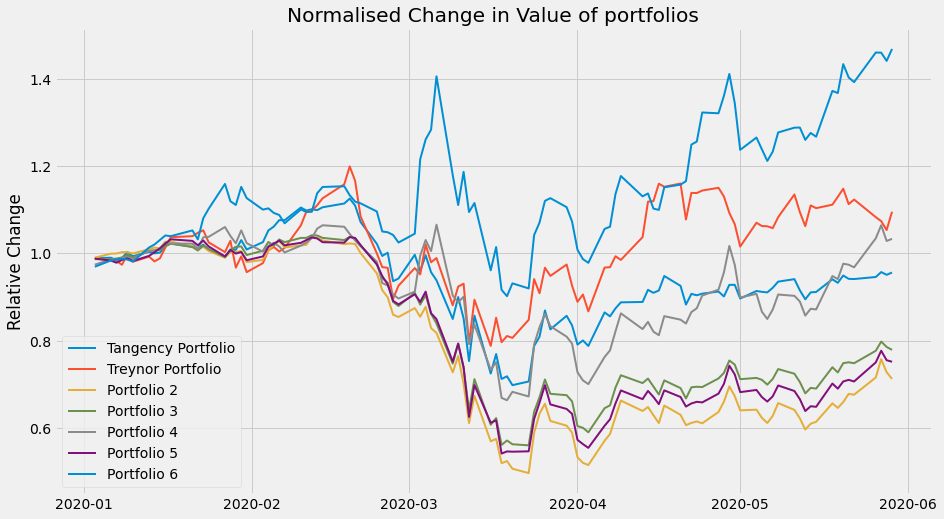

In [50]:
pfc_e.plotNormalisedPortfolios();

We see that, the tangency and Treynor portfolio have both recovered their losses from the initial effects of the coronavirus pandemic and have generated profits in the first half of this year. By comparison, the best-performing of the randomly generated portfolios has barely broken even.

As before, we can plot their risk-return profile for another visual assessment of their properties:

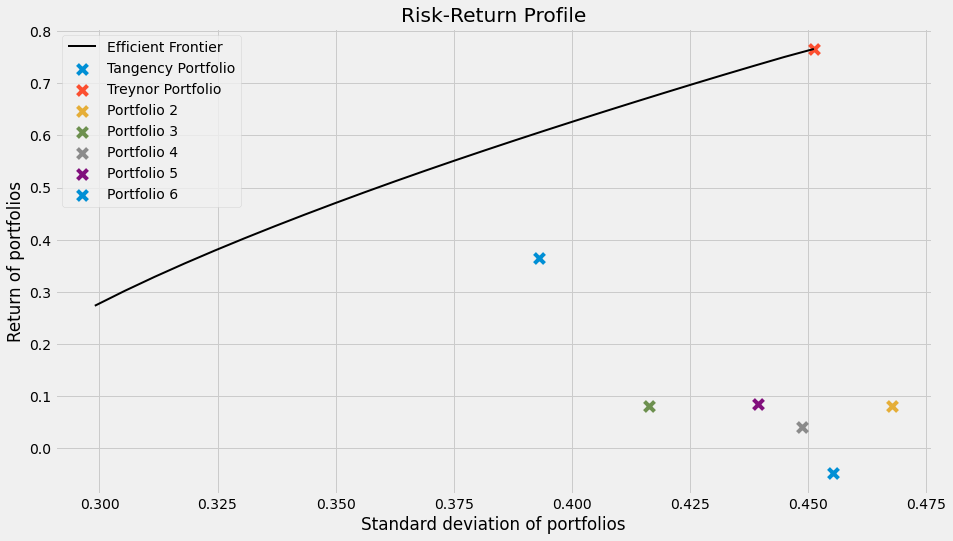

In [51]:
fig, ax = pfc_e.plotEfficientFrontier()
pfc_e.plotRiskReturn(fig, ax);

As before, the tangency portfolio plotted above is the tangency portfolio *for the testing period* whilst the efficinet frontier is for the *evaluation period*. Thus one should not expect it to lie on the new efficient frontier and that is exactly what we observe. Nevertheless, depite drifting off the efficient frontier (i.e. was not the most efficient portfolio for the evaluation period), it offered better returns than the randomly generated portfolios at lower risk.

We see that the Treynor portfolio of the *testing period* mananged to remain on the efficient frontier for the *evaluation period* as well but sits at the extreme of the efficient frontier, presenting more risk than the tangency portfolio due to lack of diversification.

# Future Directions 

We have implemented the bare bones of the modern portfolio theory. Further directions that I am currently looking at include:

1) **Solving the efficient frontier faster with a QP-solver**: whilst the convergence seems relatively stable, the current implementation using `scipy.optimize.basinhopping` is slow. The way the limits are selected is also suboptimal; the starting point of the efficient frontier should be the minimum-variance portfolio but this requires an extra costly optimisation. Instead, we conduct an MC simulation of 1000 portfolios and select the limits of the efficient frontier from the extreme values that we observe. We thus do not necessarily cover the entire range. Using a QP solver to speed up optimisation should allow me to remedy both points.

2) **Semi-variance as a better measure of risk**: the standard deviation treats the `risk` of rising on an equal footing as the risk of falling which is clearly non-sensical; a rational investor should only be concerned with downside risk. This suggests that there should be better ways to penalise risk than is done in the Sharpe ratio.

3) **Better estimators of expected returns and the covariance matrix**: when testing models on out-of-sample data, many models seem to perform less well due to overfitting on the training data. Shrinkage estimators try to account for shrinkage to return better estimators.